# Creating the CREDIT layer 

CREDIT: Custom Residential Demand Indicative Target

--------------------------------------------------------------------------

**Original code:** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Conceptualization & Methodological review :**  [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Updates, Modifications:** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Funding:** The World Bank

--------------------------------------------------------------------------
Predicting electricity demand in currently un-electrified settlement is a challenge. Many energy access efforts use the multi-tier framework (MTF) as a point of reference; OnSSET in particular, uses this approach as it provides a good basis of (investment) comparison between different levels of access. Access tiers are assigned to settlements based on selection criteria; the most common approach (also adopted in GEP) is to assign tier-targets to urban/rural settlements respectively. This approach allows for limited spatial allocation of targets let alone it does not take into account newly available spatial information.

The **Custom Residential Electricity Demand Indicative Target** (CREDIT) has been developed so as to provide a spatially explicit, alternative approach of predicting electricity demand targets in currently un-electrified settlements, by using poverty and GDP maps. The process is described step-by-step below for the example case of Malawi. This notebook has been developed to support replication of the process at any stage.

## Preparing the environment

Before starting with the code it is important that the following modules are imported. 

In [1]:
# Importing necessary modules

import geopandas as gpd
import pandas as pd
import pyproj
import os
import numpy as np
import math
import logging
import time
import itertools
import csv
import scipy.interpolate

from earthpy import clip as cl
import earthpy.plot as ep
from shapely.geometry import Point, Polygon
from shapely.geometry import box

import rasterio
from rasterio import features
import rasterio.mask
from rasterio.warp import calculate_default_transform, reproject
from rasterio.enums import Resampling
from rasterio.windows import Window
from rasterio.transform import Affine
from rasterstats import point_query
import ogr, gdal, osr, os
import pysal as ps
import affine
import fiona
import pprint

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

%matplotlib inline

C:\Users\alexl\anaconda3\envs\gep_onsset_env\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\Users\alexl\anaconda3\envs\gep_onsset_env\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


## Step 1. Collection of raw GIS data

First, we collect available data for the area/country of interest. In this case we will use the national [GDP, PPP (purchasing-power-parity) values for 2015 in constant 2011 U.S. dollars (USD)](https://gep-onsset.readthedocs.io/en/latest/GIS%20data%20collection.html#gdp-ppp). Poverty maps can be acquired from the [WorldPop](https://www.worldpop.org/geodata/listing?id=23) database in raster format. However, their availability is limited to only a few countries. Therefore here, we describe how can one use tabular data available on administrative level. Values used, indicate the share of population living below the poverty line (defined as $2/day). 

### 1.1 Importing poverty data

You may receive the poverty data in different ways; you may refer to:

- **1.1.a** in case you receive data in csv format
- **1.1.b** in case you receive data in shp
- **1.1.c** in case poverty data is already in .tiff format

#### 1.1.a Poverty data available in tabular (csv) format

**Import csv containing poverty rate/values**

In [2]:
# Define path and name of the file
csv_path = r"C:\Users\alexl\Dropbox\GitHub\gep-onsset-testing-ground\CREDIT\poverty_data\tabular"
name_of_csv_file = "malawi_poverty.csv"

In [3]:
# Import csv as pandas dataframe
poverty_data = pd.read_csv(csv_path + "\\" + name_of_csv_file)

In [4]:
poverty_data.head(3)       # in this case the column 'WBG_P2_pov_hcr' provides the headcount poverty rate in a specified year

,name_pov_2,ZSID_POVadm2,WBG_P2_pov_hcr,WBG_P2_pov_year,WBG_P2_hc_GPW,WBG_P2original_POP,WBG_P2original_POP_POV,WBG_P2original_METHOD
0,TA Mwabulambya,1154,73.600197,2010,72099.992,68700.0,50563.0,Survey+Census
1,TA Mwenemisuku,1155,74.453796,2010,22727.609,27400.0,20400.0,Survey+Census
2,TA Mwenewenya,1156,77.354301,2010,17051.180,19151.0,14814.0,Survey+Census


**Import administrative layer as vector file at the level the poverty data is available**

The tabular data above do not have a spatial index. In order to appoint them to the relative administrative unit, the latter needs to be imported.

In [5]:
# Define path and name of the file
admin_path = r"C:\Users\alexl\Dropbox\GitHub\gep-onsset-testing-ground\CREDIT\poverty_data\tabular"
admin_name_shp = "Malawi_wards.shp"

In [6]:
# Create a new geo-dataframe
admin_gdf = gpd.read_file(admin_path + "\\" + admin_name_shp)

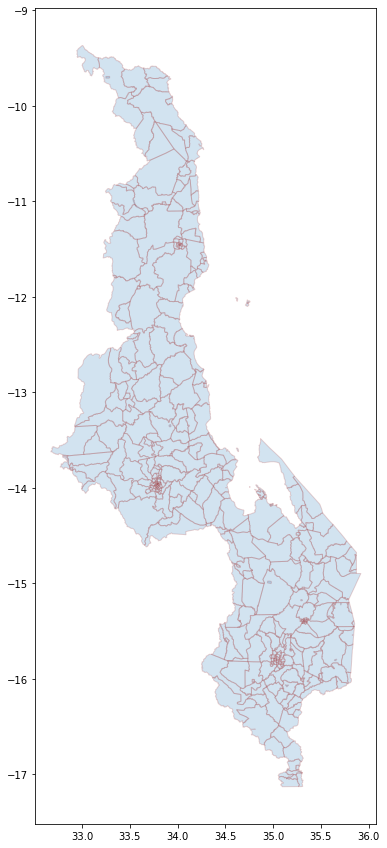

In [7]:
# Plot basemap
fig, ax = plt.subplots(figsize=(15, 15))
admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)
ax.set_aspect('equal', 'box')

# Save plot as figure 
#plt.savefig('admin level basemap.png', bbox_inches='tight')

**Merge tabular and admininstrative data**

In [8]:
# Merging the two dataframes
pov_per_admin = admin_gdf.merge(poverty_data, on="name_pov_2")     #make sure that the column is name in the same way in both dataframes & attributes match

In [9]:
# See the new columns in the geodataframe
pov_per_admin.columns

Index(['ZS_ID', 'COUNTRY', 'country_na', 'ZSID_POVad', 'name_pov_2',
       'ID_GADM2', 'geometry', 'ZSID_POVadm2', 'WBG_P2_pov_hcr',
       'WBG_P2_pov_year', 'WBG_P2_hc_GPW', 'WBG_P2original_POP',
       'WBG_P2original_POP_POV', 'WBG_P2original_METHOD'],
      dtype='object')

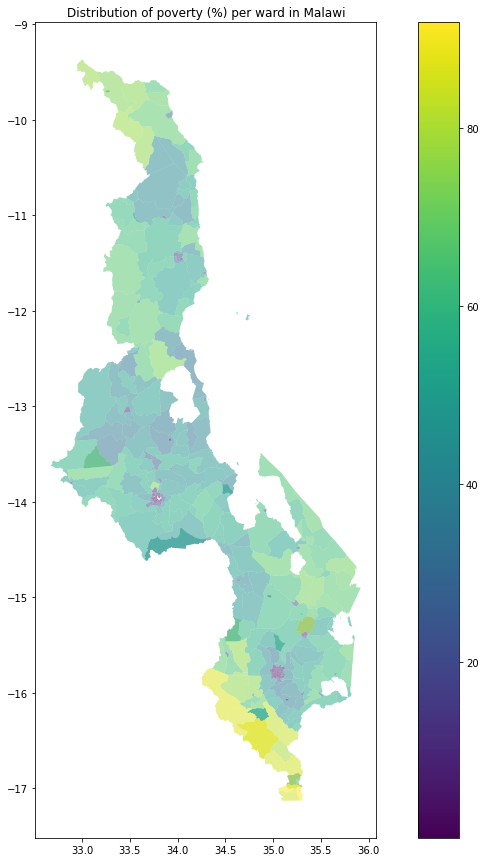

In [10]:
# Plotting for testinf
# Create the axis first
fig, ax = plt.subplots(figsize=(15, 15))

# Plot all crops
pov_per_admin.sort_values('WBG_P2_pov_hcr', ascending=True).plot(
    ax=ax, column='WBG_P2_pov_hcr', legend=True, alpha=0.5)

# Make figure aspect ratio ensure that 10x10 km square appears square
ax.set_aspect('equal', 'box')
txt = ax.set_title('Distribution of {} (%) per ward in Malawi'.format("poverty"))

# Save plot as figure 
#plt.savefig('sample_poverty_map.png', bbox_inches='tight')

---
**NOTE**

The dataset above is not projected. In case you want to spatially process the layer make sure you project it to the appropriate coordinate system.

---

**Export geodataframe as shapefile if needed**

In [11]:
# Define output path
shp_out_path = r"C:\Users\alexl\Dropbox\GitHub\gep-onsset-testing-ground\CREDIT\poverty_data\shapefile"

## You may want to project to a specific CRS before saving -- 'epsg:4326' denotes GS84; 'epsg:32737' projection for Malawi
# pov_per_admin = pov_per_admin_proj.to_crs({'init': 'epsg:32737'})    

## Export 
pov_per_admin.to_file(os.path.join(shp_out_path,"{c}.shp".format(c="Malawi_pov_per_admin_map")))

#### 1.1.b Poverty data already in shp format

In [12]:
poverty_path_shp = r"C:\Users\alexl\Dropbox\GitHub\gep-onsset-testing-ground\CREDIT\poverty_data\shapefile"
poverty_name_shp = "Malawi_pov_per_admin_map.shp"

In [13]:
# Import shapefile as a geodataframe
pov_per_admin = gpd.read_file(poverty_path_shp + "\\" + poverty_name_shp)

In [14]:
# Reproject data to the proper coordinate system for the country
pov_per_admin_proj = pov_per_admin.to_crs({'init': 'epsg:32736'})    # for Malawi

C:\Users\alexl\anaconda3\envs\gep_onsset_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


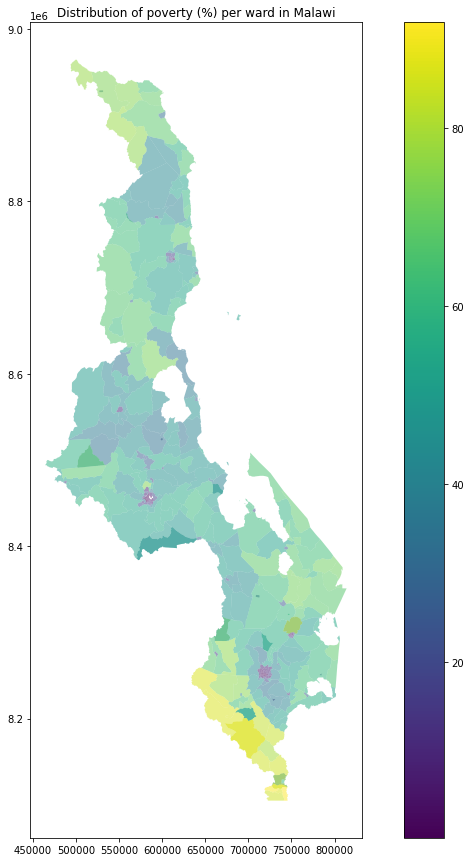

In [15]:
# Plotting
# Create the axis first
fig, ax = plt.subplots(figsize=(15, 15))

# Plot all crops
pov_per_admin_proj.sort_values('WBG_P2_pov', ascending=True).plot(
    ax=ax, column='WBG_P2_pov', legend=True, alpha=0.5)

# Make figure aspect ratio ensure that 10x10 km square appears square
ax.set_aspect('equal', 'box')
txt = ax.set_title('Distribution of {} (%) per ward in Malawi'.format("poverty"))

# Save plot as figure 
#plt.savefig('sample_poverty_map.png', bbox_inches='tight')

---
**NOTE!!**

No matter if you create the geodataframe from the .csv data or you import it directly from a shp file, the next step requires rasterization; that is, converting the vector polygon to a raster (.tiff) output.

---

**Rasterize the poverty geo-dataframe**

In [16]:
# Define rasterizaton function

def rasterize_vector(inD, outFile, field, res=0.1, dtype='float32'):
        ''' Create raster describing a field in the shapefile

        INPUT
        inD [ geopandas dataframe created from join_results ]
        outFile [ string ] - path to output raster file
        [ optional ] field [ string ] - column to rasterize from inD
        [ optional ] res [ number ] - resolution of output raster in units of inD crs
        '''

        # create metadata
        bounds = inD.total_bounds
        # calculate height and width from resolution
        width = math.ceil((bounds[2] - bounds[0]) / res)
        height = math.ceil((bounds[3] - bounds[1]) / res)

        cAffine = affine.Affine(res, 0, bounds[0], 0, res * -1, bounds[3])
        nTransform = cAffine #(res, 0, bounds[2], 0, res * -1, bounds[1])
        cMeta = {'count':1,
                 'crs': inD.crs,
                 'dtype':dtype,
                 'affine':cAffine,
                 'driver':'GTiff',
                 'transform':nTransform,
                 'height':height,
                 'width':width,
                 'nodata': 0}
        inD = inD.sort_values(by=[field], ascending=False)
        shapes = ((row.geometry, row[field]) for idx, row in inD.iterrows())
        with rasterio.open(outFile, 'w', **cMeta) as out:
            burned = features.rasterize(shapes=shapes,
                                        fill=0,
                                        all_touched=True,
                                        out_shape=(cMeta['height'], cMeta['width']),
                                        transform=out.transform,
                                        merge_alg=rasterio.enums.MergeAlg.replace)
            burned = burned.astype(cMeta['dtype'])
            out.write_band(1, burned)

In [17]:
# Rasterize & export geodataframe by calling the function

field = "WBG_P2_pov"    # Field (column) based on which the rasterization will be based
resolution = 1000     # in meters
out_raster_name = 'poverty_map.tif'
out_raster_path = r'C:\Users\alexl\Dropbox\GitHub\gep-onsset-testing-ground\CREDIT\poverty_data\raster'
outFile = os.path.join(out_raster_path, out_raster_name)

rasterize_vector(pov_per_admin_proj, outFile, field=field, res=resolution)

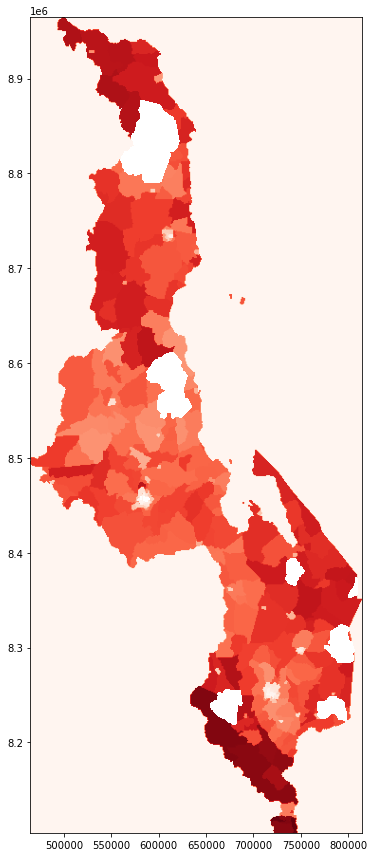

In [18]:
src = rasterio.open(out_raster_path + '\\' + out_raster_name)

# getting extent from bounds fro proper vizualization
src_extent = np.asarray(src.bounds)[[0,2,1,3]]

plt.figure(figsize = (15,15))
plt.imshow(src.read(1), cmap='Reds', extent=src_extent)

plt.show()

You may want to re-project and save the raster to the original CRS for future use and/or dissemination

In [19]:
# Define project function

def reproj(input_raster, output_raster, new_crs, factor):
    dst_crs = new_crs

    with rasterio.open(input_raster) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width*factor, src.height*factor, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(output_raster, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

In [20]:
## Set inout directories
#inpath = r"C:\Users\alexl\Dropbox\GitHub\gep-onsset-testing-ground"
#outpath= r"C:\Users\alexl\Dropbox\GitHub\gep-onsset-testing-ground"

# Provide the input raster and give a name to the output (reprojected) raster
input_raster = out_raster_path + "\\" + "poverty_map.tif"
output_raster = out_raster_path + "\\" + "poverty_map_in_CRS.tif"

# Set target CRS
new_crs = "epsg:4326"

# Provide a factor if you want zoomed in/out results; suggest keeping it to one unless fully understanding the implications
factor = 1

In [21]:
# Run function 
reproj(input_raster, output_raster, new_crs, factor)

**1.1.c Poverty data already in tiff format**

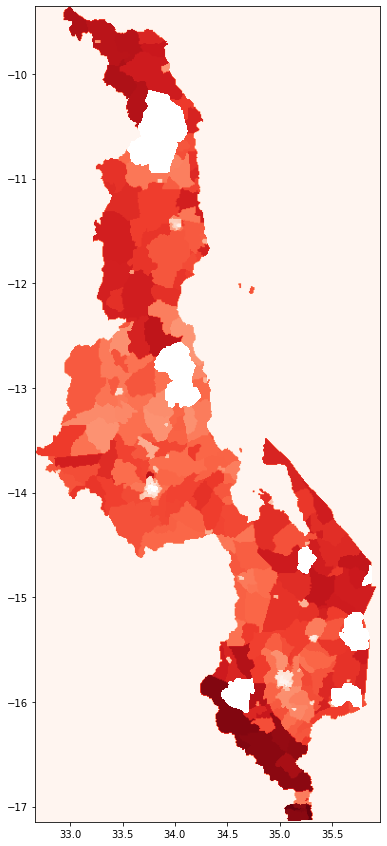

In [22]:
poverty_file = r'C:\Users\alexl\Dropbox\GitHub\gep-onsset-testing-ground\CREDIT\poverty_data\raster' + '\\' + 'poverty_map_in_CRS.tif'
src = rasterio.open(poverty_file)

# getting extent from bounds fro proper vizualization
src_extent = np.asarray(src.bounds)[[0,2,1,3]]

plt.figure(figsize = (15,15))
plt.imshow(src.read(1), cmap='Reds', extent=src_extent)

plt.show()

### 1.2 Importing GDP data

Here we assume that GDP data is retrieved in raster format (see [source](https://gep-onsset.readthedocs.io/en/latest/GIS%20data%20collection.html#gdp-ppp)). You may clip the raster using the admin mask for the area of interest, as follows.

Clipping raster to mask

In [23]:
# Import mask
mask_path = r'C:\Users\alexl\Dropbox\GitHub\gep-onsset-testing-ground\CREDIT\admin'
mask_name = 'gadm36_MWI_0.shp'

with fiona.open(mask_path + '\\' + mask_name, "r") as shapefile:
                shapes = [feature["geometry"] for feature in shapefile]

In [24]:
# Import raster, clip and export
gdp_path = r'C:\Users\alexl\Dropbox\GitHub\gep-onsset-testing-ground\CREDIT\GDP_data'
gdp_name = 'GDP_PPP_2015.tif'
with rasterio.open(gdp_path + '\\' + gdp_name) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta
    
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(gdp_path + '\\'+"GDP_2015_mw_clipped.tif", "w", **out_meta) as dest:
    dest.write(out_image)

Plotting

In [25]:
## Typical plotting as before
#gdp_file = gdp_path + '\\' + "GDP_2015_mw_clipped.tif"
#src = rasterio.open(gdp_file)

## getting extent from bounds fro proper vizualization
#src_extent = np.asarray(src.bounds)[[0,2,1,3]]
#
#plt.figure(figsize = (15,15))
#plt.imshow(src.read(3), cmap='bone', extent=src_extent)    # Band 3 represents data in 2015
#
#plt.show()

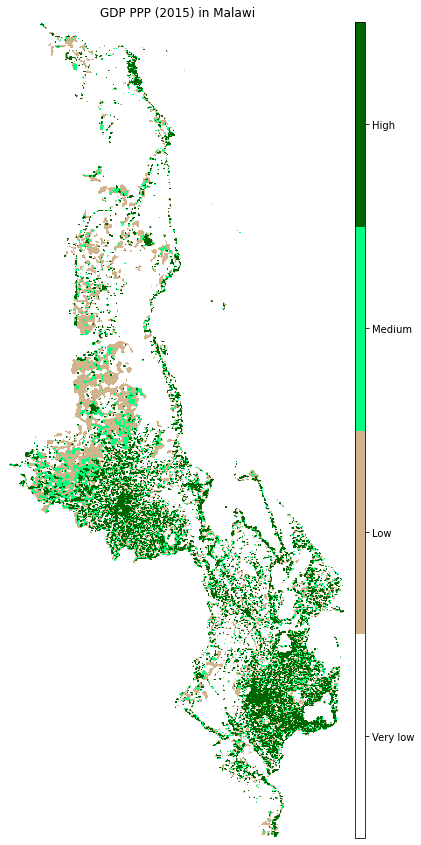

In [26]:
# Alternative way of plotting
gdp_file = gdp_path + '\\' + "GDP_2015_mw_clipped.tif"

with rasterio.open(gdp_file) as gdb_src:
    gdp = gdb_src.read(3)       # pay attention to the band here, in this case band 3 gives values of 2015

# Define the colors you want
cmap = ListedColormap(["white", "tan", "springgreen", "darkgreen"])

# Define a normalization from values -> colors
classes = 5
breaks = (np.arange(classes) / float(classes)) * gdp.max()/100    # This is an example that serves only visualization purposes at this point; see classification below for more info on dirrerent was to retrieve bins

norm = colors.BoundaryNorm(list(breaks),classes)

fig, ax = plt.subplots(figsize=(15, 15))

chm_plot = ax.imshow(gdp,
                     cmap=cmap,
                     norm=norm)

ax.set_title("GDP PPP (2015) in Malawi")

# Scale color bar to the height of the plot
cbar = ep.colorbar(chm_plot)

boundary_means = [np.mean([norm.boundaries[ii], norm.boundaries[ii - 1]])
                  for ii in range(1, len(norm.boundaries))]

category_names = ['Very low','Low', 'Medium', 'High', 'Very High']
cbar.set_ticks(boundary_means)
cbar.set_ticklabels(category_names)

ax.set_axis_off()
plt.show()

## Step 2. Re-classify raster layers

The second step on the process requires that both - poverty and GDP - maps are re-classified using a 1-5 scale as shown in the table below. 

| Initial   poverty layer | Classification| Initial GDP layer | Classification |
|-------------------------|---------------|-------------------|----------------|
| 0 ≤   pov. rate < 0.2   | 5             | I1 ≤ GDP < I3     | 1              |
| 0.2 ≤   pov. rate < 0.4 | 4             | I2 ≤ GDP < I3     | 2              |
| 0.4 ≤   pov. rate < 0.6 | 3             | I3 ≤ GDP < I4     | 3              |
| 0.6 ≤   pov. rate < 0.8 | 2             | I4 ≤ GDP < I5     | 4              |
| pov. rate ≥   0.8       | 1             | GDP ≥ I5          | 5              |

The poverty map is classified using the equal interval method. The GDP map using natural breaks mentod. The classification method can have an impact on the final product layer. Please make sure you understand the differences between the methods and select the one that suits best in your case. 

You may read about this on:

- [GISing with python](https://automating-gis-processes.github.io/CSC18/lessons/L3/reclassify.html)
- [Pysal git](https://github.com/pysal/mapclassify) & [Pysal doc](https://pysal.org/scipy2019-intermediate-gds/stochastic/gds4-visualization.html)
- [GIS wiki](http://wiki.gis.com/wiki/index.php/Classification)
- [ArcGIS support](https://pro.arcgis.com/en/pro-app/help/mapping/layer-properties/data-classification-methods.htm)

---
**NOTE!!**

In the relevant [publication](https://www.mdpi.com/1996-1073/12/7/1395) GDP is reclassifed using geometric interval classification in Arcgis. You can replicate the process if you have access to ArcMap. In this notebook we will make use of the pysal library to retrieve the classification bins using different methods and then reclassify the rasters based on those bins.

---

In [27]:
# Define a temporary directory
temp_path = r"C:\Users\alexl\Dropbox\GitHub\gep-onsset-testing-ground\CREDIT\tmp"

### Calculate classification bins

Perhaps there are faster, more sophisticated or pythonic ways to do this but here we work as follows.

- Convert raster files to geo-dataframes
- Get the bins using pysal for the selected classification method

**Convert raster files to geo-dataframes**

In [28]:
# Define functions

def pixelOffset2coord(raster, xOffset,yOffset):
    geotransform = raster.GetGeoTransform()
    originX = geotransform[0]
    originY = geotransform[3]
    pixelWidth = geotransform[1]
    pixelHeight = geotransform[5]
    coordX = originX+pixelWidth*xOffset
    coordY = originY+pixelHeight*yOffset
    return coordX, coordY

def raster2array(rasterfn, band_no):
    raster = gdal.Open(rasterfn)
    band = raster.GetRasterBand(band_no)    # Be aware of the band you need here
    array = band.ReadAsArray()
    return array

def array2shp(array,outSHPfn,rasterfn):

    # max distance between points
    raster = gdal.Open(rasterfn)
    geotransform = raster.GetGeoTransform()
    pixelWidth = geotransform[1]

    srs = osr.SpatialReference()
    srs.ImportFromWkt(raster.GetProjection())
    
    # wkbPoint
    shpDriver = ogr.GetDriverByName("ESRI Shapefile")
    if os.path.exists(outSHPfn):
        shpDriver.DeleteDataSource(outSHPfn)
    outDataSource = shpDriver.CreateDataSource(outSHPfn)
    outLayer = outDataSource.CreateLayer(outSHPfn, geom_type=ogr.wkbPoint, srs=srs )
    featureDefn = outLayer.GetLayerDefn()
    outLayer.CreateField(ogr.FieldDefn("VALUE", ogr.OFTInteger))

    # array2dict
    point = ogr.Geometry(ogr.wkbPoint)
    row_count = array.shape[0]
    for ridx, row in enumerate(array):
#         print("Printing ridx..")
#         print(ridx)
        if ridx % 100 == 0:
            print ("{0} of {1} rows processed".format(ridx, row_count))
        for cidx, value in enumerate(row):
            #print("Printing cidx..")
            #print(cidx)
            #Only positive values
            if value > 0:
                Xcoord, Ycoord = pixelOffset2coord(raster,cidx,ridx)
                point.AddPoint(Xcoord, Ycoord)
                outFeature = ogr.Feature(featureDefn)
                outFeature.SetGeometry(point)
                outFeature.SetField("VALUE", float(value))
                outLayer.CreateFeature(outFeature)
                outFeature.Destroy()
                #outDS.Destroy()

def main(rasterfn,outSHPfn, band_no):
    array = raster2array(rasterfn, band_no)
    array2shp(array,outSHPfn,rasterfn)

Convert poverty map to shp to geo-dataframe & re-classify

In [29]:
# Set inout directories
inpath_pov = r"C:\Users\alexl\Dropbox\GitHub\gep-onsset-testing-ground\CREDIT\poverty_data\raster"
outpath_pov= temp_path

# Provide the input raster and give a name to the output (reprojected) raster
rasterfn_pov = inpath_pov + "\\" + "poverty_map_in_CRS.tif"
outSHPfn_pov = outpath_pov + "\\" + "poverty_map_in_CRS.shp"

# Run the function
main(rasterfn_pov,outSHPfn_pov, band_no=1)

0 of 859 rows processed
100 of 859 rows processed
200 of 859 rows processed
300 of 859 rows processed
400 of 859 rows processed
500 of 859 rows processed
600 of 859 rows processed
700 of 859 rows processed
800 of 859 rows processed


In [30]:
# Import as geodataframe
poverty_gdf = gpd.read_file(outSHPfn_pov)

In [31]:
# Get bins based on the poverty geodataframe created above
poverty_bin = ps.viz.mapclassify.UserDefined(poverty_gdf.VALUE, bins=[20, 40, 60, 80, 100])
poverty_bin

                 UserDefined                 
 
 Lower            Upper                 Count
          x[i] <=  20.000                 988
 20.000 < x[i] <=  40.000                9682
 40.000 < x[i] <=  60.000               48491
 60.000 < x[i] <=  80.000               27444
 80.000 < x[i] <= 100.000                4916

In [32]:
# Re-classify -- code retrieved from https://gis.stackexchange.com/questions/163007/raster-reclassify-using-python-gdal-and-numpy

with rasterio.open(rasterfn_pov) as pov_src:
    # Read the raster into a (rows, cols, depth) array,
    # dstack this into a (depth, rows, cols) array,
    # the sum along the last axis (~= grayscale)
    pov_grey = np.mean(np.dstack(pov_src.read()), axis=2)

    # Read the file profile
    srcprof = pov_src.profile.copy()

#breaks = (np.arange(classes) / float(classes)) * pov_grey.max()
breaks = poverty_bin.bins

# classify the raster
classified = np.sum(np.dstack([(pov_grey < b) for b in breaks]), axis=2).reshape(1, pov_grey.shape[0], pov_grey.shape[1]).astype(np.int32)

#lookup = [(0, 3),(1, 5),(2, 4),(3, 3),(4, 2), (5, 1)]
lookup = [(0, 3)]
lookup = np.asarray(lookup)
replacer = np.arange(classified.max() + 1)
replacer[lookup[:, 0]] = lookup[:, 1]
classified = replacer[classified]

# Update the file opts to one band
srcprof.update(count=1, nodata=None, dtype=classified.dtype)

with rasterio.open(outpath_pov + '\\' + 'poverty_map_in_CRS_classified.tif', 'w', **srcprof) as dst:
    # Write the output
    dst.write(classified)

Convert gdp map to shp to geo-dataframe & re-classify

In [33]:
# Set inout directories
inpath_gdp = r"C:\Users\alexl\Dropbox\GitHub\gep-onsset-testing-ground\CREDIT\GDP_data"
outpath_gdp= temp_path

# Provide the input raster and give a name to the output (reprojected) raster
rasterfn_gdp = inpath_gdp + "\\" + "GDP_2015_mw_clipped.tif"
outSHPfn_gdp = outpath_gdp + "\\" + "GDP_2015_mw_clipped.shp"

# Run the function
main(rasterfn_gdp,outSHPfn_gdp, band_no=3)

0 of 933 rows processed
100 of 933 rows processed
200 of 933 rows processed
300 of 933 rows processed
400 of 933 rows processed
500 of 933 rows processed
600 of 933 rows processed
700 of 933 rows processed
800 of 933 rows processed
900 of 933 rows processed


In [34]:
# Import as geodataframe
gdp_gdf = gpd.read_file(outSHPfn_gdp)

In [35]:
# Get bins based on the poverty geodataframe created above
gdp_bin = ps.viz.mapclassify.NaturalBreaks(gdp_gdf.VALUE, k=5)
gdp_bin

                     NaturalBreaks                     
 
   Lower                  Upper                   Count
               x[i] <=   465631.000               64084
  465631.000 < x[i] <=  1601578.000                9017
 1601578.000 < x[i] <=  5029696.000                1208
 5029696.000 < x[i] <= 12807309.000                 168
12807309.000 < x[i] <= 42039696.000                  36

In [36]:
# Re-classify -- code retrieved from https://gis.stackexchange.com/questions/163007/raster-reclassify-using-python-gdal-and-numpy

with rasterio.open(rasterfn_gdp) as gdp_src:
    # Read the raster into a (rows, cols, depth) array,
    # dstack this into a (depth, rows, cols) array,
    # the sum along the last axis (~= grayscale)
    gdp_grey = np.mean(np.dstack(gdp_src.read()), axis=2)

    # Read the file profile
    srcprof = gdp_src.profile.copy()

#classes = 5
#breaks = (np.arange(classes) / float(classes)) * gdp_grey.max()
breaks = gdp_bin.bins

# classify the raster
classified = np.sum(np.dstack([(gdp_grey < b) for b in breaks]), axis=2).reshape(1, gdp_grey.shape[0], gdp_grey.shape[1]).astype(np.int32)

lookup = [(0, 3),(1, 5),(2, 4),(3, 3),(4, 2), (5, 1)]
lookup = np.asarray(lookup)
replacer = np.arange(classified.max() + 1)
replacer[lookup[:, 0]] = lookup[:, 1]
classified = replacer[classified]

# Update the file opts to one band
srcprof.update(count=1, nodata=None, dtype=classified.dtype)

with rasterio.open(outpath_gdp + '\\' + 'GDP_2015_mw_clipped_classified.tif', 'w', **srcprof) as dst:
    # Write the output
    dst.write(classified)

## Step 3. Sum the re-classified layers 

Here we sum the (weighted) re-classified layers to create a combined index ranging from 1-5. The operation is relatively simple and can be represented as follows:

<center>(poverty_reclas X weight_1) + (gdp_reclas X weight_2)   |   where weight_1 + weight_2 = 1</center>

---
**Note!**

- One easy way of doing this is by using raster calculator tools in a GIS environment ([Qgis](https://docs.qgis.org/2.8/en/docs/user_manual/working_with_raster/raster_calculator.html) or [ArcMap](https://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/raster-calculator.htm)).


- In case one wants to work in python only, alternative options include the [gdal_calc](https://gdal.org/programs/gdal_calc.html) code or even [rio calc](https://rasterio.readthedocs.io/en/latest/topics/calc.html). However, this requires that the raster layers are entirely alligned, as the operation is taking place on their respective arrays (see **Option 1** below)


- Alternatively, one might follow a less efficient approach that involves several transformations. Nevertheless, the approach works and yields the desired result regardless of the size of input rasters (see **Option 2** below).

Feel free to use use as per your understanding and convenience!

---

### Option 1 -- Re-sizing raster arrays based on shape

In [37]:
# Import raster layers
raster1 = rasterio.open(temp_path + "//" + "poverty_map_in_CRS_classified.tif")
raster2 = rasterio.open(temp_path + "//" + "GDP_2015_mw_clipped_classified.tif")

In [38]:
# Find window boundaries and "resample" the layer with the "bigger" representative array
bb_raster1 = box(raster1.bounds[0], raster1.bounds[1], raster1.bounds[2], raster1.bounds[3])
bb_raster2 = box(raster2.bounds[0], raster2.bounds[1], raster2.bounds[2], raster2.bounds[3])

xminR1, yminR1, xmaxR1, ymaxR1 = raster1.bounds
xminR2, yminR2, xmaxR2, ymaxR2 = raster2.bounds

intersection = bb_raster1.intersection(bb_raster2)
transform = Affine(raster1.res[0], 0.0, intersection.bounds[0], 0.0, -raster1.res[1], intersection.bounds[3])

p1Y = intersection.bounds[3] - raster1.res[1]/2
p1X = intersection.bounds[0] + raster1.res[0]/2
p2Y = intersection.bounds[1] + raster1.res[1]/2
p2X = intersection.bounds[2] - raster1.res[0]/2


row1R1 = int((ymaxR1 - p1Y)/raster1.res[1])
row2R1 = int((ymaxR1 - p2Y)/raster1.res[1])
col1R1 = int((p1X - xminR1)/raster1.res[0])
col2R1 = int((p2X - xminR1)/raster1.res[0])
width1 = col2R1 - col1R1 + 1
height1 = row2R1 - row1R1 + 1


arr_raster1 = raster1.read(1, window=Window(col1R1, row1R1, width1, height1))
arr_raster2 = raster2.read(1, window=Window(col1R1, row1R1, width1, height1))

arr_sum = (arr_raster1*0.5) + (arr_raster2*0.5)

sample_output = r"C:\Users\alexl\Dropbox\GitHub\gep-onsset-testing-ground\CREDIT\sample_output"

with rasterio.open(sample_output + "//" + "AHP_option_1.tif",
                   'w',
                   driver='GTiff',
                   height=arr_sum.shape[0],
                   width=arr_sum.shape[1],
                   count=1,
                   dtype=arr_sum.dtype,
                   crs=raster1.crs,
                   transform=transform) as dst:

    dst.write(arr_sum, 1)

dst.close()

---

**Note!**
In case the process reports arraey out of bounds simply re-assign raster1 and raster 2.


---

In [40]:
# Clip raster file to admin level
# Import raster, clip and export
clip_path = sample_output
clip_name = 'AHP_option_1.tif'
with rasterio.open(clip_path + '\\' + clip_name) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta
    
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(sample_output + '\\'+"clipped_sum_.tif", "w", **out_meta) as dest:
    dest.write(out_image)

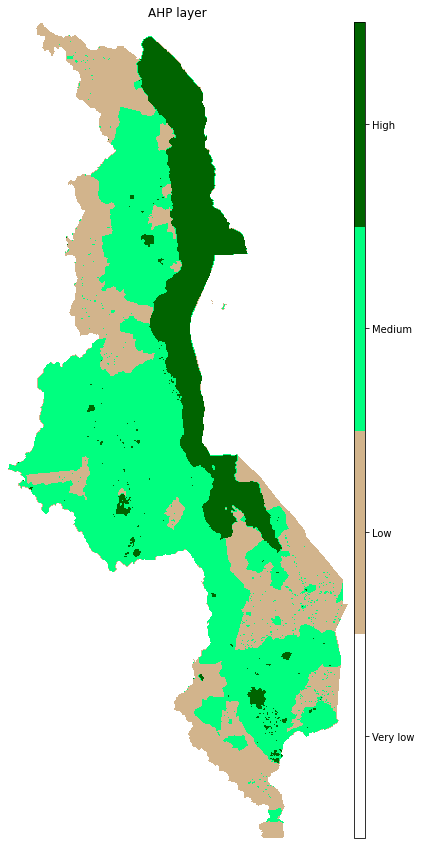

In [41]:
# Alternative way of plotting
sample_file = sample_output + '\\'+"clipped_sum_.tif"

with rasterio.open(sample_file) as src:
    sample_out = src.read(1)       # pay attention to the band here, in this case band 3 gives values of 2015

# Define the colors you want
cmap = ListedColormap(["white", "tan", "springgreen", "darkgreen"])

# Define a normalization from values -> colors
classes = 5
breaks = (np.arange(classes) / float(classes)) * sample_out.max()    # This is an example that serves only visualization purposes at this point; see classification below for more info on dirrerent was to retrieve bins

norm = colors.BoundaryNorm(list(breaks),classes)

fig, ax = plt.subplots(figsize=(15, 15))

chm_plot = ax.imshow(sample_out,
                     cmap=cmap,
                     norm=norm)

ax.set_title("AHP layer")

# Scale color bar to the height of the plot
cbar = ep.colorbar(chm_plot)

boundary_means = [np.mean([norm.boundaries[ii], norm.boundaries[ii - 1]])
                  for ii in range(1, len(norm.boundaries))]

category_names = ['Very low','Low', 'Medium', 'High', 'Very High']
cbar.set_ticks(boundary_means)
cbar.set_ticklabels(category_names)

ax.set_axis_off()
plt.show()

### Option 2 -- Converting raster to geodataframe and work accordingly

### 3.1 Create a "base" point layer as a csv file

Here we use one of the geo-dataframes (either poverty or gdp) to create a vector point layer that we will use as base. It is suggested to use the one that yield the resolution that best suits each case. Here we proceed with the GDP geo-dataframe.

In [42]:
# Stored in memory from previous steps
gdp_gdf.head(3)

,VALUE,geometry
0,433274,POINT (32.99167 -9.36667)
1,185689,POINT (33.00000 -9.36667)
2,464211,POINT (32.98333 -9.37500)


In [43]:
# Creating an index ("idx") column to be used for merging dataframes later on
gdp_gdf['idx'] = range(1, len(gdp_gdf) + 1)

In [44]:
# Extract geometry as X,Y coordinates
gdp_gdf['lon'] = gdp_gdf['geometry'].x
gdp_gdf['lat'] = gdp_gdf['geometry'].y

In [45]:
# Export the dataframe as csv file 
gdp_gdf.to_csv(os.path.join(temp_path,"{c}.csv".format(c='base')), index=False)

### 3.2 Extract raster values to points defined by the "base" csv file

---

**Note!** In case this takes time, you may want to clip the rasters using the region's admin layer as mask (see code below). In the sample case the difference in time gained is small and we use directly the rasters files from the previous step.

---


In [46]:
## Import raster, clip and export
#a_input = r"C:\Users\alexl\Dropbox\GitHub\gep-onsset-testing-ground\CREDIT\poverty_data\raster\poverty_map_in_CRS_classified.tif"
#b_input = r"C:\Users\alexl\Dropbox\GitHub\gep-onsset-testing-ground\CREDIT\GDP_data\GDP_2015_mw_clipped_classified.tif"
#c_output = r"C:\Users\alexl\Dropbox\GitHub\gep-onsset-testing-ground\CREDIT\tmp"
#
#with rasterio.open(a_input) as src:
#    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
#    out_meta = src.meta
#    
#out_meta.update({"driver": "GTiff",
#                 "height": out_image.shape[1],
#                 "width": out_image.shape[2],
#                 "transform": out_transform})
#
#with rasterio.open(c_output + '\\'+"pov_clipped.tif", "w", **out_meta) as dest:
#    dest.write(out_image)
#    
#with rasterio.open(b_input) as src:
#    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
#    out_meta = src.meta
#    
#out_meta.update({"driver": "GTiff",
#                 "height": out_image.shape[1],
#                 "width": out_image.shape[2],
#                 "transform": out_transform})
#
#with rasterio.open(c_output + '\\'+"gdp_clipped.tif", "w", **out_meta) as dest:
#    dest.write(out_image)

In [47]:
raster_path = temp_path
raster_files =[]
csvoutpath = temp_path

print ("Reading independent variables...")

for i in os.listdir(raster_path):
    if i.endswith('.tif'):
        raster_files.append(i)  

print ("Extracting raster values to points...")

for i in raster_files:
    print("Extracting " + i + " values...")
    src_filename = raster_path + "\\" + i 
    li_values = list()

    src_ds=gdal.Open(src_filename) 
    gt=src_ds.GetGeoTransform()
    rb=src_ds.GetRasterBand(1)
    #ds=ogr.Open(shp_filename)
    ds = ogr.Open(gdp_gdf.to_json())
    lyr=ds.GetLayer()
    
    for feat in lyr:
        geom = feat.GetGeometryRef()
        feat_id = feat.GetField('idx')
        mx,my=geom.GetX(), geom.GetY()  #coord in map units

        #Convert from map to pixel coordinates.
        #Only works for geotransforms with no rotation.
        px = int((mx - gt[0]) / gt[1]) #x pixel
        py = int((my - gt[3]) / gt[5]) #y pixel

        intval=rb.ReadAsArray(px,py,1,1)
        li_values.append([feat_id, intval[0]])
        
    print ("Writing " + i + " values to csv...")
    
    with open(csvoutpath + "\\" + i.split('.')[0] + '.csv', 'w') as csvfile:
        wr = csv.writer(csvfile)
        wr.writerows(li_values) 

Reading independent variables...
Extracting raster values to points...
Extracting GDP_2015_mw_clipped_classified.tif values...
Writing GDP_2015_mw_clipped_classified.tif values to csv...
Extracting poverty_map_in_CRS_classified.tif values...
Writing poverty_map_in_CRS_classified.tif values to csv...


### 3.3 Merge all csv files & create a dataframe from them

In [48]:
pov_gdp = pd.read_csv(temp_path + "\\" + "base.csv")

csv_files = []

print ("Reading csv files...")

for i in os.listdir(csvoutpath):
    if i.endswith('.csv'):
        csv_files.append(i)  

for i in csv_files:
    print('Reading...'+ i)    
    df_csv = pd.read_csv(csvoutpath + "//" + i, index_col=None, header=None)
    df_csv.iloc[:,1] = df_csv.iloc[:,1].astype(str)
    df_csv.iloc[:,1] = df_csv.iloc[:,1].str.replace('[','')
    df_csv.iloc[:,1] = df_csv.iloc[:,1].str.replace(']','')
    columnName = i.split('.')[0]
    print("Merging..." + columnName)
    pov_gdp[columnName] = df_csv.iloc[:,1]

Reading csv files...
Reading...base.csv
Merging...base
Reading...GDP_2015_mw_clipped_classified.csv
Merging...GDP_2015_mw_clipped_classified
Reading...poverty_map_in_CRS_classified.csv
Merging...poverty_map_in_CRS_classified


In [49]:
pov_gdp.head(2)

,VALUE,geometry,idx,lon,lat,base,GDP_2015_mw_clipped_classified,poverty_map_in_CRS_classified
0,433274,POINT (32.99166685311781 -9.366666772737126),1,32.991667,-9.366667,geometry,1,2
1,185689,POINT (33.00000018649863 -9.366666772737126),2,33.000000,-9.366667,POINT (32.99166685311781 -9.366666772737126),1,2


**Cleaning and prepping**

In [50]:
#Delete geometry column
pov_gdp = pov_gdp.drop(["base", "VALUE", "geometry"], axis=1)

In [51]:
pov_gdp.GDP_2015_mw_clipped_classified.unique()

array(['1', '2', '3', '4', '5'], dtype=object)

In [52]:
# Convert nan to 0
pov_gdp["GDP_2015_mw_clipped_classified"] = pov_gdp["GDP_2015_mw_clipped_classified"].fillna(3)
pov_gdp["poverty_map_in_CRS_classified"] = pov_gdp["poverty_map_in_CRS_classified"].fillna(3)

# Changing dtype of classigfied columns
pov_gdp["GDP_2015_mw_clipped_classified"] = pov_gdp["GDP_2015_mw_clipped_classified"].astype(int)
pov_gdp["poverty_map_in_CRS_classified"] = pov_gdp["poverty_map_in_CRS_classified"].astype(int)

In [53]:
pov_gdp.head(2)

,idx,lon,lat,GDP_2015_mw_clipped_classified,poverty_map_in_CRS_classified
0,1,32.991667,-9.366667,1,2
1,2,33.000000,-9.366667,1,2


### 3.4 Adding the two classified columns using weighting factors

In [54]:
# Selecting weights Note that the sum must equal 1
weight_pov = 0.5
gdp_pov = 0.5

pov_gdp['AHP_index'] = (pov_gdp['GDP_2015_mw_clipped_classified']*gdp_pov) + (pov_gdp['poverty_map_in_CRS_classified']*weight_pov)

In [55]:
pov_gdp.head(2)

,idx,lon,lat,GDP_2015_mw_clipped_classified,poverty_map_in_CRS_classified,AHP_index
0,1,32.991667,-9.366667,1,2,1.5
1,2,33.000000,-9.366667,1,2,1.5


In [56]:
# Creating a geo-dataframe - appointing geometry attribute
pov_gdp['geometry'] = list(zip(pov_gdp['lon'], pov_gdp['lat']))
pov_gdp['geometry'] = pov_gdp['geometry'].apply(Point)
pov_gdp_gdf = gpd.GeoDataFrame(pov_gdp, geometry='geometry', crs={'init': 'epsg:4326'})

C:\Users\alexl\anaconda3\envs\gep_onsset_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


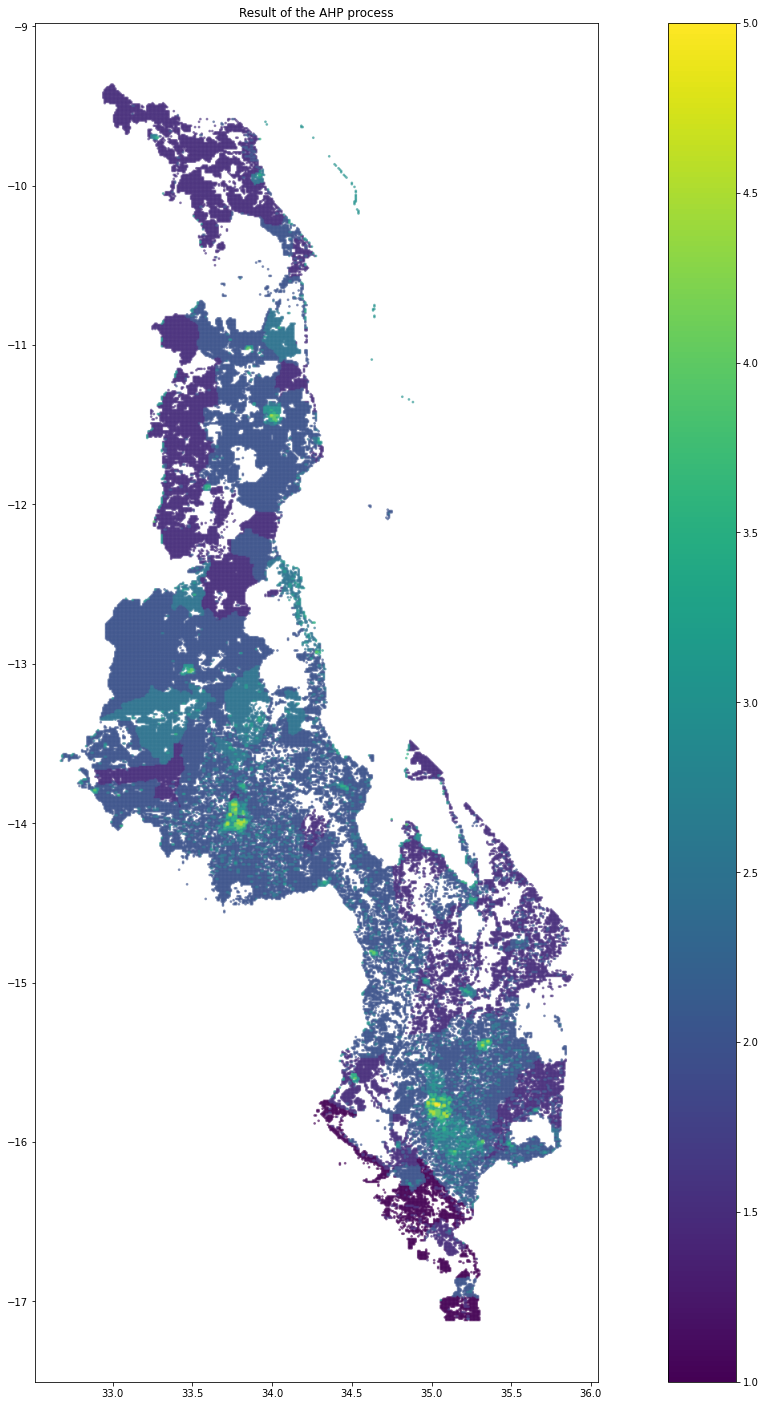

In [57]:
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 25))
#admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)
pov_gdp_gdf.sort_values('AHP_index', ascending=True).plot(ax=ax, column='AHP_index',
                           legend=True, markersize=3, cmap="viridis",
                           figsize=(20, 20), alpha=0.5)
# Make figure aspect ratio ensure that 10x10 km square appears square
ax.set_aspect('equal', 'box')
txt = ax.set_title('Result of the AHP process'.format(""))

# Save plot as figure 
plt.savefig(os.path.join(sample_output, 'AHP_result_option2.png'), bbox_inches='tight')
#logging.getLogger('matplotlib.font_manager').disabled = True



## Step 4. Interpolate and create the CRETID layer


In [58]:
x = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
y = [1, 8.8, 176.65, 344.5, 512.35, 680.2]
y_interp = scipy.interpolate.interp1d(x, y)

pov_gdp_gdf["CREDIT"] = y_interp(pov_gdp_gdf["AHP_index"])


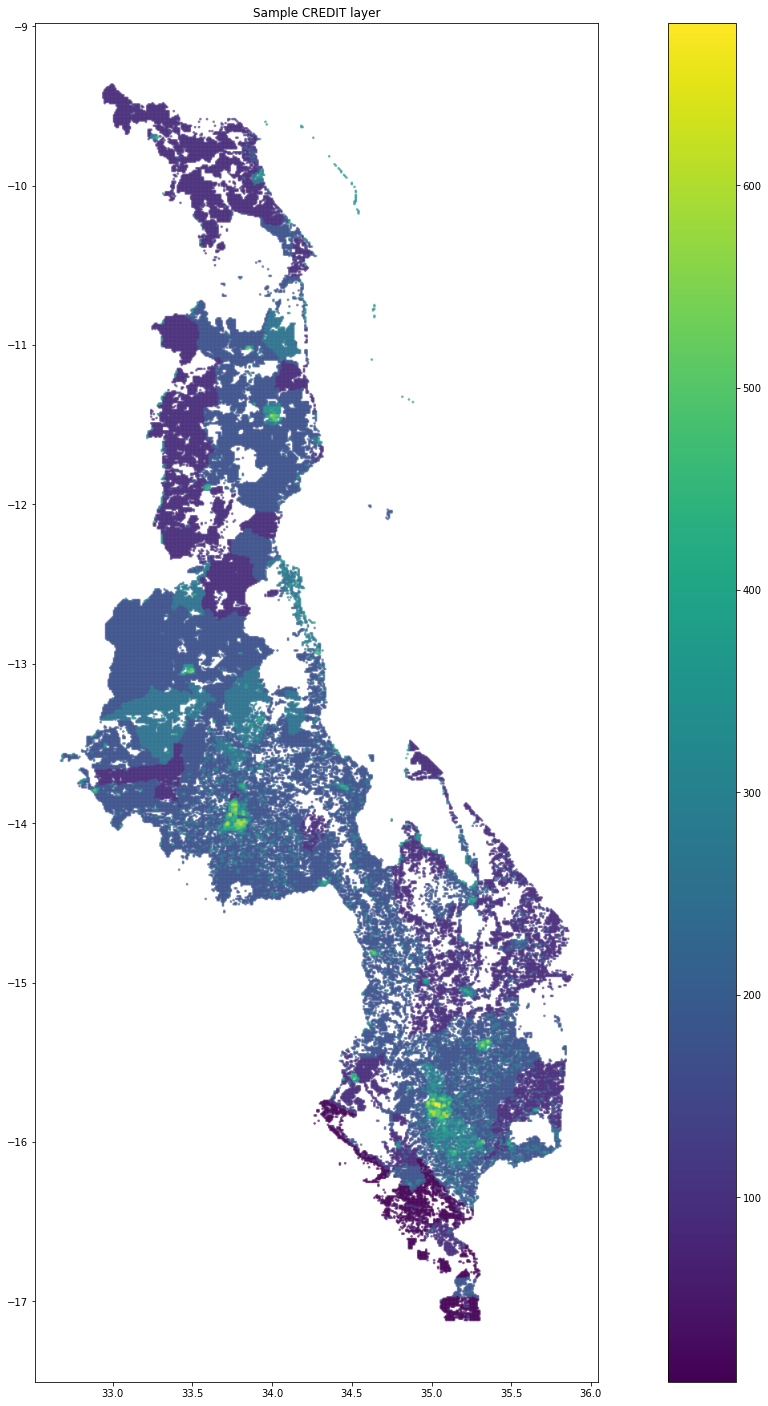

In [59]:
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 25))
#admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)
pov_gdp_gdf.sort_values('CREDIT', ascending=True).plot(ax=ax, column='CREDIT',
                           legend=True, markersize=3, cmap="viridis",
                           figsize=(20, 20), alpha=0.5)
# Make figure aspect ratio ensure that 10x10 km square appears square
ax.set_aspect('equal', 'box')
txt = ax.set_title('Sample CREDIT layer'.format(""))

# Save plot as figure 
plt.savefig(os.path.join(sample_output, 'Sample_result.png'), bbox_inches='tight')
logging.getLogger('matplotlib.font_manager').disabled = True

In [60]:
# Reproject data to the proper coordinate system for the country
pov_gdp_gdf_proj = pov_gdp_gdf.to_crs({'init': 'epsg:32736'})    # for Malawi

C:\Users\alexl\anaconda3\envs\gep_onsset_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [61]:
# Rasterize & export geodataframe by calling the function

field = "CREDIT"    # Field (column) based on which the rasterization will be based
resolution = 1000     # in meters
out_raster_name = 'CREDIT.tif'
out_raster_path = r"C:\Users\alexl\Dropbox\GitHub\gep-onsset-testing-ground\CREDIT\sample_output"
outFile = os.path.join(out_raster_path, out_raster_name)

rasterize_vector(pov_gdp_gdf_proj, outFile, field=field, res=resolution)